In [1]:
import numpy as np
import pandas as pd
from problem_formulation import get_model_for_problem_formulation
from ema_workbench.analysis import parcoords
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
from collections import defaultdict

from ema_workbench import (
    Model,
    MultiprocessingEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
    Policy
)

In [52]:
INPUT_FILENAME = 'output/20230614T1118_results_seed_ds_pareto_with_constrains'
results = pd.read_csv(INPUT_FILENAME + '.csv')

In [3]:
model, steps = get_model_for_problem_formulation(7)

In [4]:
policies = results
policies = policies[[o.name for o in model.levers]]
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,4,0,0,4,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,2,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,3,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [5]:
policies_to_evaluate = []

for _, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(_), **policy.to_dict()))

In [6]:
#n_scenarios = 50
n_scenarios = 1000
with MultiprocessingEvaluator(model) as evaluator:
    results2 = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)

100%|████████████████████████████████████| 21000/21000 [33:50<00:00, 10.34it/s]


## Calculating score based on signal-to-noise ratio

In [7]:
def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std

In [8]:
experiments, outcomes = results2

overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        sn_ratio = s_to_n(value, outcome.kind)
        scores[outcome.name] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T
scores

,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths
0,8.710051e+13,4.768145e-07,14.313114,5.868612e+17,0.008425
1,2.086970e+14,6.935944e-07,8.958949,6.155889e+17,0.005621
10,1.893612e+14,6.198466e-07,4.181364,7.306011e+17,0.008158
11,5.498951e+14,1.622033e-06,0.000000,1.381263e+18,0.015223
12,3.842442e+14,1.119999e-06,0.099168,2.087486e+18,0.023694
13,5.839044e+14,1.719388e-06,1.427724,1.141780e+18,0.018536
14,4.258943e+14,1.246019e-06,0.551653,2.023418e+18,0.021522
15,4.901277e+14,1.434687e-06,0.883862,1.544815e+18,0.020779
16,3.605717e+14,1.122949e-06,5.475833,7.894157e+17,0.007969
17,3.605717e+14,1.122949e-06,3.726284,7.604190e+17,0.007670


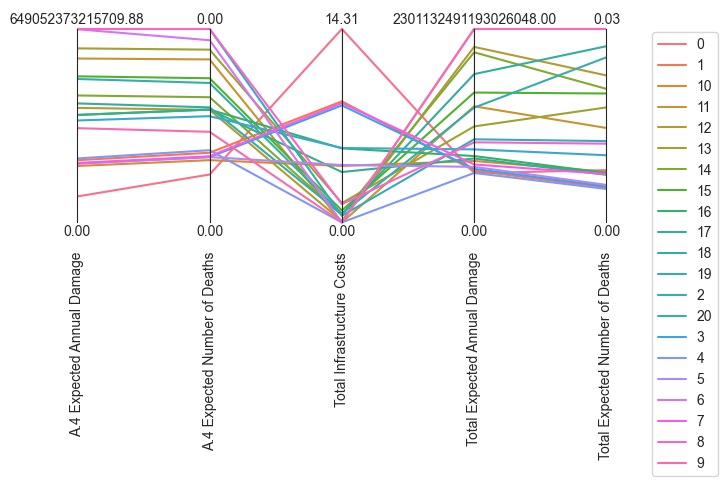

In [16]:
data = scores
limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

# sns.color_palette() has 10 colors.
colors = sns.color_palette("husl", 21)
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

Since with 21 colors it's hard to match line to a policy, we can plot half of the policies and select the ones that are pareto dominant in terms of lowest signal to noise ratio. Let's first make a graph for first 11, next for remaining 10.

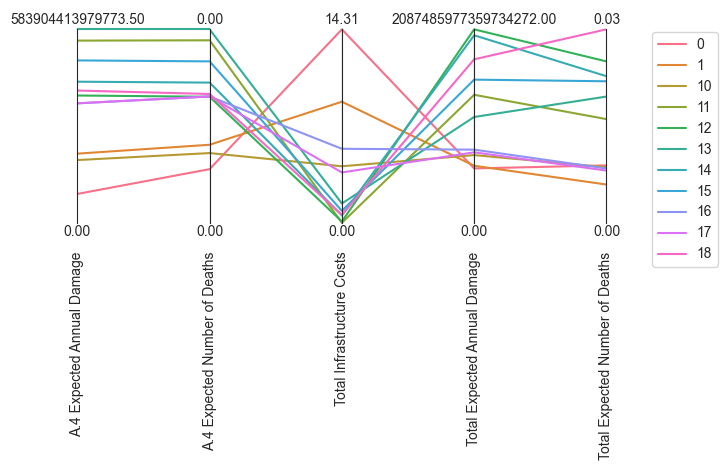

In [24]:
data = scores.head(11)
limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

# sns.color_palette() has 10 colors.
colors = sns.color_palette("husl", 11)
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

Pareto dominating policies are among this set: 0,10,1,11,12,13,14,16,17. Still the green lines can be consufed so for safety we keep all 3 (12,13,14).

Note that here we are determining pareto dominance by eye, so other visual inspection approaches are also valid. 

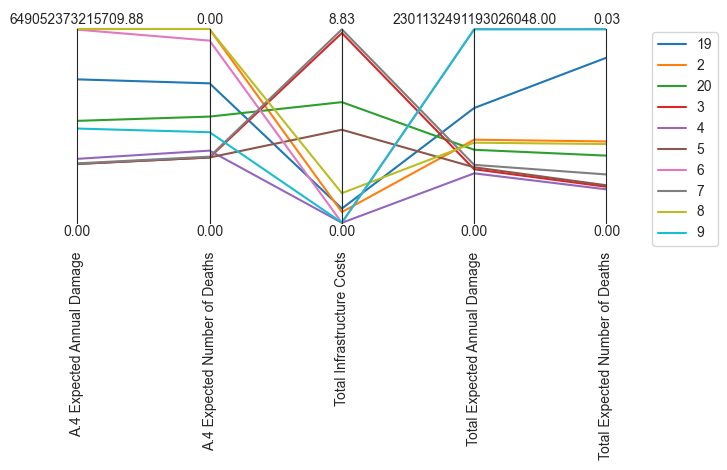

In [22]:
data = scores.tail(10)
limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

colors = sns.color_palette()
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()

plt.show()

Pareto dominating policies are among this set: 4,5,6,7. This was we keep 13 policies for further filtering with maximum regret metric.

## Calculating robustness using maximum regret

### Definitions

Regret: the difference between policy performance in a specific scenario versus the performance of the best possible result in that scenario (or versus a reference policy).

Maximum regret: max(regret) across all scenarios

Defined for each policy under each scenario

Objective: minimize regret


In [10]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [37]:
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevent information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # filter out rows that are not for policies kept according to signal/ratio metric. 
    data = data[data['policy'].isin(['0','10','1','11','12','13','14','16','17','4','5','6','7'])]

    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    overall_regret[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

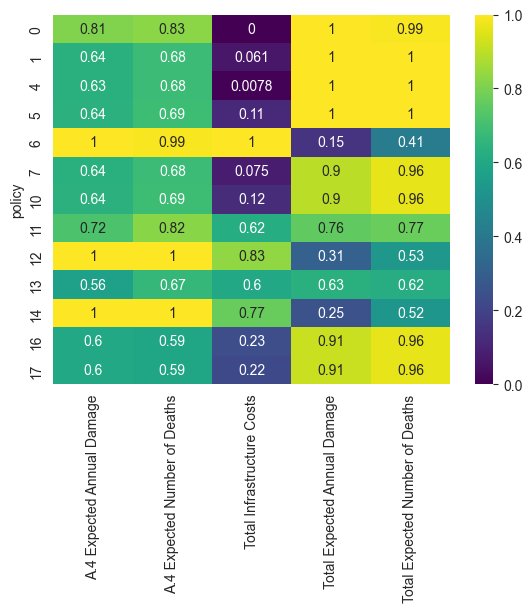

In [38]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

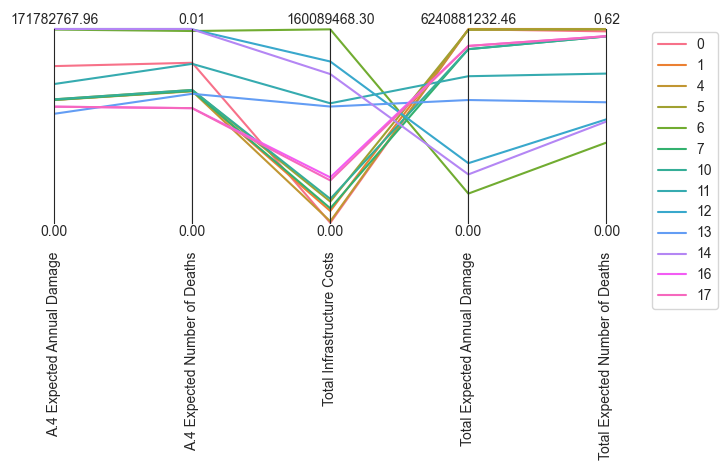

In [39]:
# as sns.color_palette() has less 10 colors.
colors = sns.color_palette("husl", 13)

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

Assuming we want to keep 10 most robust policies, we want to filter out 3 that have the highest regret. 
2 marine blues are pareto dominated. Also 0 (dominated by 4 or 5, not clear due to similar colors). To determine which policies are the marine blue lines we need to plot them separately, these are two among 7,10,11,12.

In [43]:
max_regret

,A.4 Expected Annual Damage,A.4 Expected Number of Deaths,Total Infrastructure Costs,Total Expected Annual Damage,Total Expected Number of Deaths
policy,,,,,
0,1.391471e+08,0.006533,0.000000e+00,6.240881e+09,0.611553
1,1.091560e+08,0.005385,9.783252e+06,6.237051e+09,0.617987
4,1.090255e+08,0.005369,1.241788e+06,6.240881e+09,0.617987
5,1.096176e+08,0.005423,1.758083e+07,6.224060e+09,0.617987
6,1.715748e+08,0.007830,1.600895e+08,9.421432e+08,0.256251
7,1.091832e+08,0.005385,1.198860e+07,5.601464e+09,0.595420
10,1.096176e+08,0.005423,1.978618e+07,5.601464e+09,0.595420
11,1.232214e+08,0.006489,9.890595e+07,4.728612e+09,0.476656
12,1.717828e+08,0.007898,1.334694e+08,1.923043e+09,0.330530


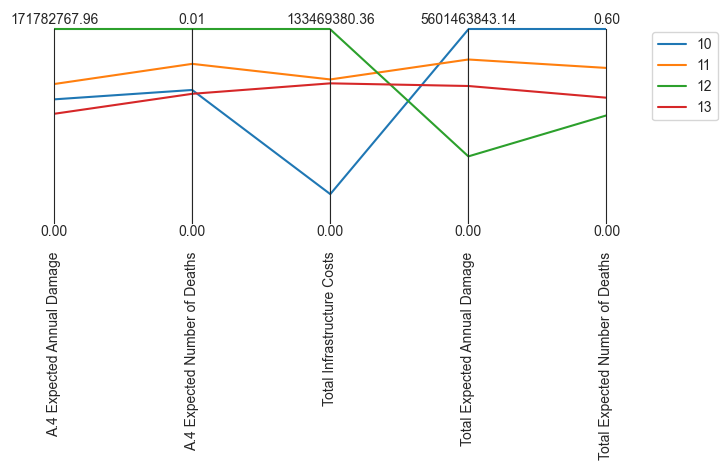

In [47]:
colors = sns.color_palette()

# Note here we pass row numbers, not policy numbers!
data = max_regret.iloc[[6,7,8,9]]

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, ['A.4 Expected Annual Damage', 'A.4 Expected Number of Deaths', 'Total Infrastructure Costs',
               'Total Expected Annual Damage', 'Total Expected Number of Deaths']] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()

So 12 and 11 are also Pareto dominated. 

Note that if with the visual inspection of Pareto dominance you are not able to arrive at suitable number/ranking of policies you can make choices based on additional constraints or prioritization of robustness per outcome.

We remain with 10 policies: 10,1,13,14,16,17 4,5,6,7. This will be used to discover scenarios to later run MS-MORDM.

In [48]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,4,0,0,4,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,2,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,3,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,1,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [49]:
policies = policies.iloc[['10','1','13','14','16','17','4','5','6','7']]

In [56]:
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
10,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
13,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
14,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
16,0,0,0,0,0,0,1,0,0,0,...,0,2,0,0,2,0,0,1,0,0
17,0,0,0,0,0,0,1,0,0,0,...,0,2,0,0,2,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,2,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,3,0,0


In [58]:
policies.reset_index(drop=True,inplace=True)
policies

,0_RfR 0,0_RfR 1,0_RfR 2,1_RfR 0,1_RfR 1,1_RfR 2,2_RfR 0,2_RfR 1,2_RfR 2,3_RfR 0,...,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,A.5_DikeIncrease 2
0,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,2,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,3,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,2,0,0,2,0,0,1,0,0
5,0,0,0,0,0,0,1,0,0,0,...,0,2,0,0,2,0,0,2,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,4,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,4,0,0,3,0,0,2,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,3,0,0,3,0,0,3,0,0


In [59]:
policies.to_csv(INPUT_FILENAME + '_robust.csv')

## Calculating robustness using regret distribution

In [14]:
policy_regret = defaultdict(dict)
for key, value in overall_regret.items():
    for policy in value:
        policy_regret[policy][key] = value[policy]

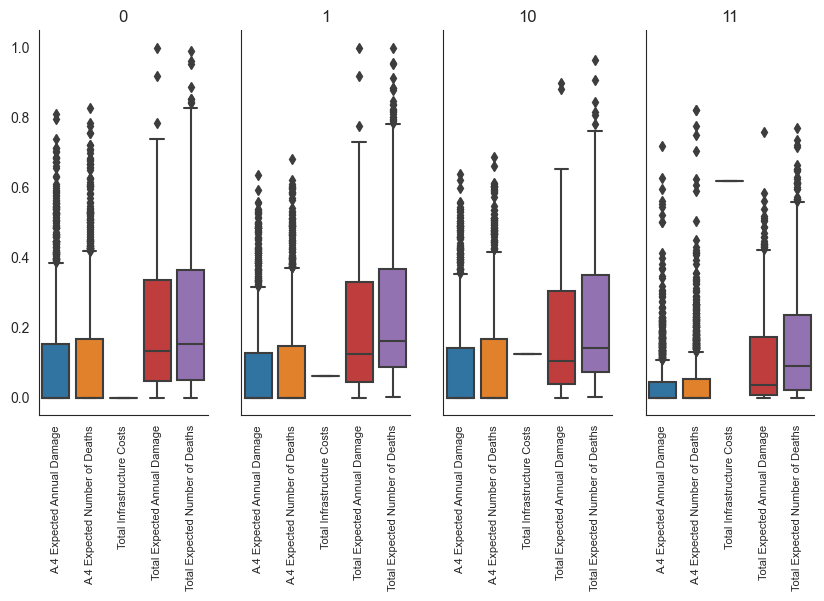

In [15]:
# this generates a 2 plots with a shared y and x axis
fig, axes = plt.subplots(ncols=4, figsize=(10,5), 
                         sharey=True, sharex=True)

# to ensure easy iteration over the axes grid, we turn it
# into a list. Because there are four plots, I hard coded
# this. 

# zip allows us to zip together the list of axes and the list of 
# key value pairs return by items. If we iterate over this
# it returns a tuple of length 2. The first item is the ax
# the second items is the key value pair.
for ax, (policy, regret) in zip(axes, policy_regret.items()):
    data = pd.DataFrame(regret)

    # we need to scale the regret to ensure fair visual
    # comparison. We can do that by divding by the maximum regret
    data = data/max_regret.max(axis=0)
    b = sns.boxplot(data=data, ax=ax)
    b.tick_params(labelsize=8, axis = 'x', rotation=90)
    
    # removes top and left hand black outline of axes
    sns.despine()
    
    # ensure we know which policy the figure is for
    ax.set_title(str(policy))
plt.show()

## Post-robustness scenario discovery